In [ ]:
import os
import matplotlib.pyplot as plt
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [ ]:
import torch
print(torch.cuda.is_available())


False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path1 = '/content/drive/My Drive/PROJECT/Text Data/train.tsv'
path2 = '/content/drive/My Drive/PROJECT/Text Data/dev.tsv'


In [ ]:
import pandas as pd

df_train = pd.read_csv(path1, sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv(path2, sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [ ]:
df_train

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj
...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,edsb738
43406,Always thought that was funny but is it a refe...,6,ee7fdou
43407,What are you talking about? Anything bad that ...,3,efgbhks
43408,"More like a baptism, with sexy results!",13,ed1naf8


In [ ]:
df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))
df_dev['List of classes'] = df_dev['Class'].apply(lambda x: x.split(','))
df_dev['Len of classes'] = df_dev['List of classes'].apply(lambda x: len(x))

In [ ]:
df_train

,Text,Class,ID,List of classes,Len of classes
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1
3,To make her feel threatened,14,ed7ypvh,[14],1
4,Dirty Southern Wankers,3,ed0bdzj,[3],1
...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,edsb738,[18],1
43406,Always thought that was funny but is it a refe...,6,ee7fdou,[6],1
43407,What are you talking about? Anything bad that ...,3,efgbhks,[3],1
43408,"More like a baptism, with sexy results!",13,ed1naf8,[13],1


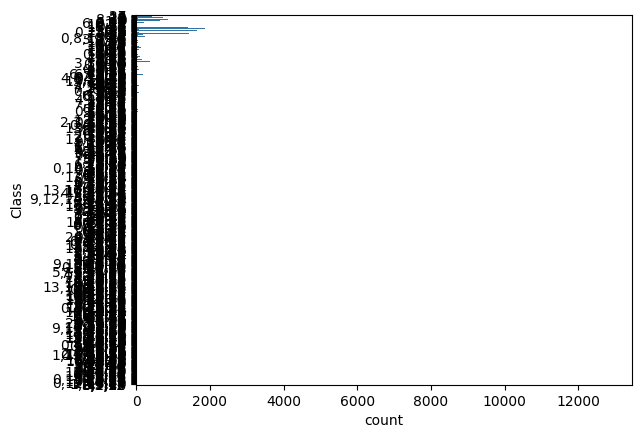

In [ ]:
import seaborn as sns
sns.countplot(y=df_train['Class'],data=df_train)
plt.show()

In [ ]:
df_train.isnull().sum()

,0
Text,0
Class,0
ID,0
List of classes,0
Len of classes,0


In [ ]:
df_train["Class"].value_counts()

,count
Class,
27,12823
0,2710
4,1873
15,1857
1,1652
...,...
"6,15,22",1
"9,10,19",1
"7,10,25",1


In [ ]:
with open('/content/drive/My Drive/PROJECT/Text Data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [ ]:
emotion_file = open("/content/drive/My Drive/PROJECT/Text Data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [ ]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [ ]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)
df_dev['Emotions'] = df_dev['List of classes'].apply(idx2class)

In [ ]:
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}

In [ ]:
def EmotionMapping(emotion_list):
    map_list = []

    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i == 'neutral':
            map_list.append('neutral')

    return map_list

In [ ]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_dev['Mapped Emotions'] = df_dev['Emotions'].apply(EmotionMapping)

In [ ]:
df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

df_dev['anger'] = np.zeros((len(df_dev),1))
df_dev['disgust'] = np.zeros((len(df_dev),1))
df_dev['fear'] = np.zeros((len(df_dev),1))
df_dev['joy'] = np.zeros((len(df_dev),1))
df_dev['sadness'] = np.zeros((len(df_dev),1))
df_dev['neutral'] = np.zeros((len(df_dev),1))

In [ ]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_dev[i] = df_dev['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [ ]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0


In [ ]:
df_dev.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,neutral
0,Is this in New Orleans?? I really feel like th...,27,edgurhb,[27],1,[neutral],[neutral],0,0,0,0,0,1
1,"You know the answer man, you are programmed to...","4,27",ee84bjg,"[4, 27]",2,"[approval, neutral]","[joy, neutral]",0,0,0,1,0,1
2,I've never been this sad in my life!,25,edcu99z,[25],1,[sadness],[sadness],0,0,0,0,1,0
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2,"[4, 27]",2,"[approval, neutral]","[joy, neutral]",0,0,0,1,0,1
4,He could have easily taken a real camera from ...,20,eepig6r,[20],1,[optimism],[joy],0,0,0,1,0,0


In [ ]:
df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['neutral'] == 1].index, inplace=True)
df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['disgust'] == 1].index, inplace=True)

In [ ]:
df_train.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)
df_dev.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [ ]:
df_train['Text'] = df_train['Text'].apply(text_preprocessing_pipeline)
df_dev['Text'] = df_dev['Text'].apply(text_preprocessing_pipeline)

In [ ]:
df_train.reset_index(drop=True).to_csv("train.csv", index=False)
df_dev.reset_index(drop=True).to_csv("val.csv", index=False)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)


In [ ]:
df_train.head()

,Text,ID,anger,fear,joy,sadness
0,why the fuck is bayless isoing,eezlygj,1,0,0,0
1,to make her feel threatened,ed7ypvh,0,1,0,0
2,dirty southern wankers,ed0bdzj,1,0,0,0
3,omg peyton is not good enough to help us in th...,edvnz26,0,0,0,0
4,yes i heard abt the f bombs that has to be why...,ee3b6wu,0,0,1,0


In [ ]:
print(df_train.shape)
print(df_dev.shape)

(28427, 6)
(3564, 6)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8

EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
target_cols = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_cols

['anger', 'fear', 'joy', 'sadness']

In [ ]:
class Model(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]




        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = Model(df_train, tokenizer, MAX_LEN)
valid_dataset = Model(df_dev, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class ModelClass(torch.nn.Module):
    def __init__(self):
        super(ModelClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        # self.fc = torch.nn.Linear(768,5)
        self.fc = torch.nn.Linear(768, 4)  # Change 5 to 4


    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        print(features.shape) # output_2 = self.l2(output_1)
        output = self.fc(features)

        return output

model = ModelClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ModelClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
accumulation_steps = 4  # Change as needed



In [ ]:
def train(epoch):
    model.train()
    optimizer.zero_grad()
    for step, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets) / accumulation_steps
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        if step % 500 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()


0

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

torch.Size([8, 768])
Epoch: 0, Loss: 0.16993187367916107
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768]

KeyboardInterrupt: 

In [ ]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)

            mask = data['mask'].to(device, dtype = torch.long)

            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
           # print(mask.shape,ids.shape,token_type_ids.shape)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7539281705948373
F1 Score (Micro) = 0.825405055087492
F1 Score (Macro) = 0.7490829466850484
